<font size = "5"> **Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

#  Fitting of Zero-Loss Peak

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

The zero-loss peak in an EELS spectrum gives us two important infomations:
    * the origin of the energy-scale
    * the zero-loss peak is the resolution function of our spectrum
    
Often we need to subtract or know this resolution function very accurately for a precise analysis of EELS spectra.

The area under the peak gives us the number of electron that are not inelatically scattered, and in relation to the total count a measure for the thickness of the sample.

## First we import the relevant packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.EELS_tools  as eelst 


from scipy.optimize import leastsq  ## fitting routine of scipy

import os


# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
windows
pyTEM version:  0.12.2019.3


## Load and plot a spectrum
please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details

<IPython.core.display.Javascript object>


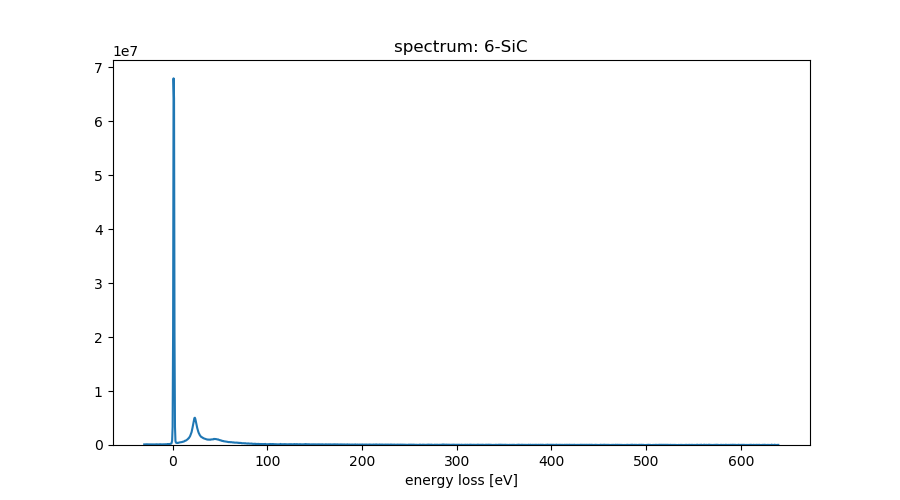

In [2]:
filename = './example_data/6-SiC.dm3'

### Load file
try:
    h5_file.close()
except: 
    pass
h5_file = ft.h5open_file(filename)

## To choose the spectru yourself 
# uncomment the follwing line and comment out the line above
#h5_file = ft.h5open_file()

current_channel = h5_file['Measurement_000/Channel_000']

# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)


# plot according to what data type is in your file
if tags['data_type'] == 'EELS_spectrum':
    ## Start plotting
    plt.figure(figsize(9,5))
    
    plt.plot(tags['energy_scale'],tags['data']);
    plt.title('spectrum: '+ tags['title'])
    plt.xlabel('energy loss [eV]')
    plt.ylim(0);
else:
    print('Find an EELS spectrum to load, please!')

### Important Parameters in an EELS spectrum

In [3]:
for key in tags:
    if key in  ['data', 'energy_scale'] :
        print( key, ' -- with length: ', tags[key].shape)
    else:
        print(key, ': ',tags[key])
print('\n additional_tags \n')
additional_tags = dict(current_channel.attrs)
for key in additional_tags:
    print(key, ': ',additional_tags[key])

aberrations :  {}
acceleration_voltage :  100000.0
camera_length :  0.0
collection_angle :  50.0
convergence_angle :  30.0
exposure_spectrum :  0.001
image_type :  Image
integration_time :  0.2
machine_id :  utc
number_of_frames :  200
platform :  Windows-10-10.0.18362-SP0
pyUSID_version :  0.0.6.2
time_last_modified :  1446752655.0
timestamp :  2020_02_11-11_02_04
title :  6-SiC
data_type :  EELS_spectrum
data  -- with length:  (1340,)
spectral_scale_x :  0.5
spectral_units_x :  eV
spectral_origin_x :  -30.0
spectral_size_x :  1340.0
energy_scale  -- with length:  (1340,)

 additional_tags 

acceleration_voltage :  100000.0
camera_length :  0.0
collection_angle :  50.0
convergence_angle :  30.0
exposure_spectrum :  0.001
image_type :  Image
integration_time :  0.2
machine_id :  utc
number_of_frames :  200
platform :  Windows-10-10.0.18362-SP0
pyUSID_version :  0.0.6.2
time_last_modified :  1446752655.0
timestamp :  2020_02_11-11_02_04


## Simple Zero-Loss Integration

The inelastic mean free path is hard to determine and depends on the effective collection angle (convolution of collection and convergence angle) and the acceleration voltage. None of these parameters are likely to be tabulated for your experimental set-up.

However, the relative thickness is a valuable parameter to judge your sample location and the validity of your spectrum.


In a good sample 70 to 90% of the electrons do not interact. 
The relative thickness $t$ in terms of the inelatic mean free path (IMFP) is given by:
$$ t = \ln\left(\frac{I_{total}}{I_{ZL}} \right) * IMFP$$

with:

$I_{total}$: total intensity of spectrum

$I_{ZL}$:  intensity of zero-loss peak

We first estimate the intensity of the zero-loss peak by a summation of the spectrum in a specific energy-loss range.


In [12]:
spectrum = tags['data'].copy()
energy_scale = tags['energy_scale'].copy()
offset = current_channel['spectral_origin_x'][()]
dispersion = current_channel['spectral_scale_x'][()]
start = int((-2-offset)/dispersion)
end   = int((4-offset)/dispersion)

sumZL = sum(spectrum[start:end])
sumSpec = sum(spectrum)

print(f"Counts in zero-loss {sumZL:.0f} , total counts {sumSpec:.0f}")
print(f"{(sumSpec-sumZL)/sumSpec*100:.1f} % of spectrum interact with specimen")      

tmfp = np.log(sumSpec/sumZL)
print ('Sample thickness in Multiple of the ')
print (f'thickness [IMFP]: {tmfp:.3f}')


Counts in zero-loss 182798480 , total counts 412188878
55.7 % of spectrum interact with specimen
Sample thickness in Multiple of the 
thickness [IMFP]: 0.813


## Fitting the Zero-Loss with a Gausian
While a Gaussian does not describe the shape of the zero-loss peak well, we will use it to determine the zero-loss peak position.

The maximum of the fitted Gaussian is then the origin of the energy scale.

In [13]:
###
# This function is also in the EELS_tools of pyTEMlib

def fixE( spec, energy):
    
    startx = np.argmax(spec)
    end = startx+3
    start = startx-3
    for i in range(10):
        if spec[startx-i]<0.3*spec[startx]:
            start = startx-i
        if spec[startx+i]<0.3*spec[startx]:
            end = startx+i
    if end-start<3:
        end = startx+2
        start = startx-2
    
    x = np.array(energy[start:end])
    y = np.array(spec[start:end]).copy()
    
    y[np.nonzero(y<=0)] = 1e-12


    def gauss(x, p): # p[0]==mean, p[1]= area p[2]==fwhm, 
        return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))

    def errfunc(p, x, y):
        err = (gauss(x, p)-y )/np.sqrt(y) # Distance to the target function
        return err
    
    p0 = [energy[startx],1000.0,1] # Inital guess is a normal distribution
    p1, success = leastsq(errfunc, p0[:], args=(x, y))

    fit_mu, area, FWHM = p1
    
    return FWHM, fit_mu

In [16]:

FWHM, fit_mu = fixE( spectrum, energy_scale)
print(f'FWHM: {FWHM:.2f} eV , with shift of {fit_mu:.2f} eV')

FWHM: 1.15 eV , with shift of 1.24 eV


Fit of Zero Loss from channel  57  to  65
Fit of Zero Loss from   -1.5 eV to  2.5 eV
Zero-loss position was 1.24 eV
Corrected energy axis
Width (FWHM) is 1.12 eV
Probability  is 43.32 %
Thickness is 0.837 * IMFP
Goodness of Fit:  119.8205046192329 %


<IPython.core.display.Javascript object>


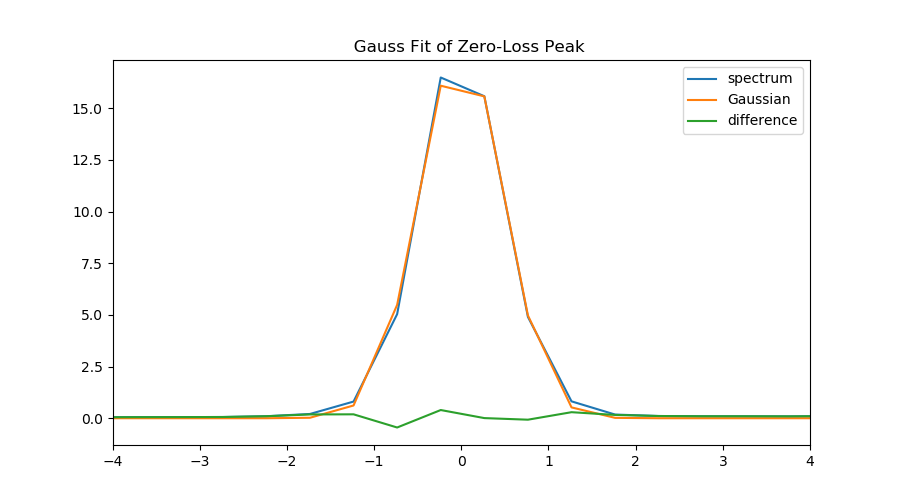

Sum of Gaussian:  178556596.02703452
Sum of Spectrum:  412188860.0
thickness [IMFP]:  0.8365760365372077


In [29]:
energy_scale = tags['energy_scale'].copy()
tags['Gap'] = Gap = 2

## energy range of fit
startx = int(abs(offset/dispersion ))+1 ## zero eV
widthx = int(abs(Gap   /dispersion )) ## fit width
## We need 6 parameter to fit the resolution function
## and so at least 6 channels for the fit
if widthx*2 < 6:
    Gap = 3*dispersion
    widthx = 3

endx = int(startx+widthx)
startx = int(startx-widthx)

print('Fit of Zero Loss from channel ', startx, ' to ',endx)
print('Fit of Zero Loss from  ', startx*dispersion+offset, 'eV to ',endx*dispersion+offset, 'eV')

# energy scale and spectrum in the fitting window
x = energy_scale[startx:endx]
y = np.array(spectrum[startx:endx]).flatten()


def gauss(x, p): 
    """
    Gaussian distribution
    Input: 
    p: list or array  p[0]=position, p[1]= area p[2]==fwhm, 
    x: energy axis 
    """
    p[2] = abs(p[2])
    return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))


# Fit a Gaussian
y[np.nonzero(y<=0)] = 1e-12
p0 = [0,1000.0,1] # Inital guess is a normal distribution
errfunc = lambda p, x, y: (gauss(x, p) - y)/np.sqrt(y) # Distance to the target function
p1, success = leastsq(errfunc, p0[:], args=(x, y)) # The Fit

print(f'Zero-loss position was {p1[0]:.2f} eV')
energy_scale=energy_scale-p1[0]
print('Corrected energy axis')
p1[0]=0.0
Gauss = gauss(energy_scale,p1)


print(f'Width (FWHM) is {p1[2]:.2f} eV')
print(f'Probability  is {sum(Gauss)/sumSpec*1e2:.2f} %')
tmfp = np.log(sumSpec/sum(Gauss))
print(f'Thickness is {tmfp:.3f} * IMFP')

err = (y - gauss(x, p1))/np.sqrt(y)
print ('Goodness of Fit: ' ,sum(err**2)/len(y)/sumSpec*1e2, '%')


abs(offset/dispersion )
start =int((-2-offset)/dispersion)
end = int((8-offset)/dispersion)

plt.figure()

plt.plot(energy_scale, spectrum/sumSpec*1e2,label='spectrum')
plt.plot(energy_scale, Gauss/sumSpec*1e2, label='Gaussian')
plt.plot(energy_scale, (spectrum-Gauss)/sumSpec*1e2, label='difference')
plt.legend()
plt.title ('   Gauss Fit of Zero-Loss Peak')
plt.xlim(-4,4)
Izl = Gauss.sum()
Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)
print('Sum of Gaussian: ', Izl)
print('Sum of Spectrum: ', Itotal)
print ('thickness [IMFP]: ', tmfp)


## Fitting the Zero-Loss with a Product of Two Lorentzians
To better describe the full shape we use the product of two Lorentzians.

Compare the residuals of the Gaussian and Lorentzian fit. 

You will zoom in closely to see the difference between experimental and model zero-loss peak here.

32 92 60
Energy range for fit of zero-loss: -15.24 to 14.76
Fit of a Product of two Lorentzians
Positions:  -0.42255151149563824 0.45890055937670754 Distance:  -0.8814520708723458
Width:  0.7798151362072302 0.8210745902274875
Areas:  22751.558073019485 22396.666993892824
Goodness of Fit: 0.069057%


<IPython.core.display.Javascript object>


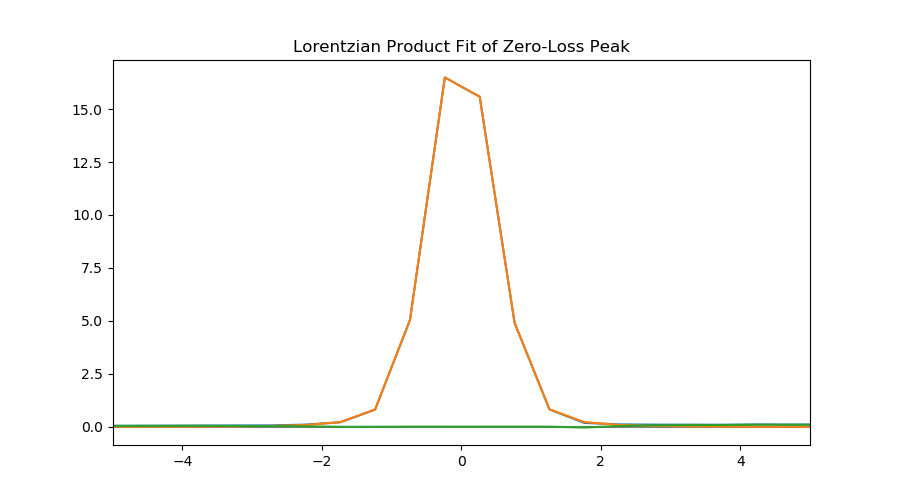

Sum of Zero-Loss: 183052148 counts
Sum of Spectrum: 412188864 counts
thickness [IMFP]: 0.81171


In [30]:
#################################################################
## fit Zero Loss peak with ZLfunct =
##  = convolution of Gauss with a product of two Lorentzians
##################################################################        
width = 30


startx = np.argmax(spectrum)
endx = startx+width
startx = startx-width
print (startx, endx, endx-startx)


x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

print(f"Energy range for fit of zero-loss: {energy_scale[startx]:.2f} to {energy_scale[endx]:.2f}")

#guess = [0.02, 8000000, 0.1, 0.2, 1000,0.2,0.5, 1000,-0.5,-1.3, 1.01,1.0]
guess = [ 0.2, 1000,0.02,0.2, 1000,0.2 ]

p0 = np.array(guess)

def ZL(p, y, x):
    err = (y - eelst.ZLfunc(p,  x))#/np.sqrt(y)
    return err

pZL, lsq = leastsq(ZL, p0, args=(y, x), maxfev=2000)
print('Fit of a Product of two Lorentzians')
print('Positions: ',pZL[2],pZL[5], 'Distance: ',pZL[2]-pZL[5])
print('Width: ', pZL[0],pZL[3])
print('Areas: ', pZL[1],pZL[4])
err = (y - eelst.ZLfunc(pZL,  x))/np.sqrt(np.abs(y))
print (f'Goodness of Fit: {sum(err**2)/len(y)/sumSpec*1e2:.5}%')

zLoss = eelst.ZLfunc(pZL, energy_scale)

plt.figure()
plt.plot(energy_scale,spectrum/sumSpec*1e2 , label = 'spectrum')

plt.plot(energy_scale,   zLoss/sumSpec*1e2, label ='resolution function')
plt.plot(energy_scale,  (spectrum-zLoss)/sumSpec*1e2 , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
plt.xlim(-5,5)
plt.hlines(0, energy_scale[0], energy_scale[-1],color = 'gray')
Izl = zLoss.sum()
Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')

## Conclusion

We use a Gaussian fit to determine the zero energy channel and thus the origin of the energy-scale

We use a product of two Lorentzians to fit the zero-loss peak, we will use that fit as the resolution function for further analysis (everythin we measure is convoluted by that function).

Here we used the area under the zero-loss peak to determine the relative thickness ( a relative thickness of 0.3 * IMFP is considered ideal for most experiments)

## Navigation
### Back: [Fit Zero-Loss](FitZeroLoss.ipynb)
### Next:  [Analysing Low-Loss Spectra with Drude Theory](DrudeLL.ipynb)

### Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
### Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)